# Sessão 1: Preparação do Ambiente de Análise
<div class="markdown">
Nesta sessão, vamos preparar tudo para a nossa análise. Carregaremos nosso dataset completo, recriaremos as features, e o mais importante, carregaremos e treinaremos nosso Modelo Campeão final, com os hiperparâmetros e o scale_pos_weight que definimos como ótimos. Em seguida, faremos as previsões no nosso conjunto de teste para criar um DataFrame de resultados que será a base de toda a nossa exploração.
</div>

In [1]:
import joblib
import pandas as pd
import sqlite3
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc

In [2]:
# Configurações
DB_NAME = "../nba_shots.sqlite"

# --- Carregar os Dados ---
conn = sqlite3.connect(DB_NAME)
query = "SELECT * FROM players"
df_players = pd.read_sql_query(query, conn)
conn.close()

print("Dados carregados com sucesso!")
print(f"Total de players no dataset: {len(df_players)}")
df_players = df_players.rename(columns={'id': 'player_id'})
display(df_players.head())

Dados carregados com sucesso!
Total de players no dataset: 765


,player_id,player_name
0,2544,LeBron James
1,2617,Udonis Haslem
2,2738,Andre Iguodala
3,101108,Chris Paul
4,200752,Rudy Gay


In [3]:
# Defina o nome do arquivo
model_filename_joblib = '../models/xgb_best_model.joblib'

# Use a função joblib.load()
best_model = joblib.load(model_filename_joblib)

print(f"Modelo '{model_filename_joblib}' carregado com sucesso.")

Modelo '../models/xgb_best_model.joblib' carregado com sucesso.


In [4]:
X_test_id = pd.read_csv('../data/X_test_id.csv')
y_test_id = pd.read_csv('../data/y_test_id.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')
df = pd.read_csv('../data/df.csv')


In [5]:
df

,game_id,player_id,team_id,loc_x,loc_y,shot_distance,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,time_remaining_in_game,shot_angle,shot_made_flag
0,22400001,1642258,1610612737,-168,205,26,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,2863,50.664963,0
1,22400001,1630552,1610612737,-136,-1,13,Driving Floating Bank Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,2858,-0.421285,0
2,22400001,1630552,1610612737,157,203,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,2810,127.718331,1
3,22400001,1630811,1610612737,-176,184,25,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,2747,46.273030,0
4,22400001,203991,1610612737,-25,8,2,Putback Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2744,17.744672,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655442,22201218,1630550,1610612766,61,55,8,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Right Side(R),8-16 ft.,216,137.960936,0
655443,22201218,1631109,1610612766,5,12,1,Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,186,112.619865,1
655444,22201218,1630177,1610612766,-100,185,21,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,158,61.606981,0
655445,22201218,1630177,1610612766,1,6,0,Driving Finger Roll Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,121,99.462322,1


In [6]:

df = df.merge(df_players[['player_id', 'player_name']], on='player_id', how='left')

In [7]:
df_encoded = X_test_id.drop(columns=['game_id','player_id','team_id', 'loc_x', 'loc_y', 'shot_distance', 'time_remaining_in_game', 'shot_angle'])

In [8]:
df_encoded

,action_type_Alley Oop Layup shot,action_type_Cutting Dunk Shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank Hook Shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Floating Bank Jump Shot,action_type_Driving Floating Jump Shot,action_type_Driving Hook Shot,...,shot_zone_basic_Right Corner 3,shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),shot_zone_range_24+ ft.,shot_zone_range_8-16 ft.,shot_zone_range_Back Court Shot,shot_zone_range_Less Than 8 ft.
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131085,False,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
131086,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,True
131087,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
131088,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False


In [9]:
# --- Criar DataFrame de Resultados ---
y_pred = best_model.predict(X_test)

df_results = df.loc[X_test.index].copy()

df_results['true_outcome'] = y_test
df_results['predicted_outcome'] = y_pred

df_results.head(10)

,game_id,player_id,team_id,loc_x,loc_y,shot_distance,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,time_remaining_in_game,shot_angle,shot_made_flag,player_name,true_outcome,predicted_outcome
0,22400001,1642258,1610612737,-168,205,26,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,2863,50.664963,0,Zaccharie Risacher,0,0
1,22400001,1630552,1610612737,-136,-1,13,Driving Floating Bank Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,2858,-0.421285,0,Jalen Johnson,0,0
2,22400001,1630552,1610612737,157,203,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,2810,127.718331,1,Jalen Johnson,1,0
3,22400001,1630811,1610612737,-176,184,25,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,2747,46.273030,0,Keaton Wallace,1,1
4,22400001,203991,1610612737,-25,8,2,Putback Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2744,17.744672,1,Clint Capela,0,0
5,22400001,1642258,1610612737,10,13,1,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2723,127.568592,1,Zaccharie Risacher,1,1
6,22400001,1642258,1610612737,53,111,12,Floating Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,2690,115.523425,0,Zaccharie Risacher,1,0
7,22400001,1642258,1610612737,-10,17,1,Putback Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2687,59.534455,0,Zaccharie Risacher,0,0
8,22400001,1642258,1610612737,-10,1,1,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2686,5.710593,0,Zaccharie Risacher,0,1
9,22400001,1642258,1610612737,0,0,0,Tip Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2683,90.000000,0,Zaccharie Risacher,0,0


# Sessão 2: Análise de Erros - Onde o Modelo se Confunde?
<div class="markdown">
Agora, vamos isolar os erros do modelo. Vamos criar dois DataFrames: um para os Falsos Positivos (o modelo previu 'Convertido', mas o resultado foi 'Errado') e outro para os Falsos Negativos (o modelo previu 'Errado', mas o resultado foi 'Convertido'). Analisar as características desses arremessos nos dirá muito sobre os vieses e pontos cegos do nosso modelo.
</div>

In [10]:
# Isolar os Falsos Positivos (FP)
df_fp = df_results[(df_results['true_outcome'] == 0) & (df_results['predicted_outcome'] == 1)]
print(f"Total de Falsos Positivos: {len(df_fp)}")

# Isolar os Falsos Negativos (FN)
df_fn = df_results[(df_results['true_outcome'] == 1) & (df_results['predicted_outcome'] == 0)]
print(f"Total de Falsos Negativos: {len(df_fn)}")

print("\n--- Análise dos Falsos Positivos (Modelo foi otimista demais) ---")
print("Estatísticas da distância do arremesso:")
display(df_fp['shot_distance'].describe())
print("\nTipos de arremesso mais comuns:")
display(df_fp['action_type'].value_counts().head(5))

print("\n\n--- Análise dos Falsos Negativos (Modelo foi pessimista demais) ---")
print("Estatísticas da distância do arremesso:")
display(df_fn['shot_distance'].describe())
print("\nTipos de arremesso mais comuns:")
display(df_fn['action_type'].value_counts().head(5))

Total de Falsos Positivos: 24987
Total de Falsos Negativos: 25309

--- Análise dos Falsos Positivos (Modelo foi otimista demais) ---
Estatísticas da distância do arremesso:


count    24987.000000
mean        14.120863
std         10.731004
min          0.000000
25%          3.000000
50%         14.000000
75%         25.000000
max         84.000000
Name: shot_distance, dtype: float64


Tipos de arremesso mais comuns:


action_type
Jump Shot                     7213
Pullup Jump shot              2880
Driving Layup Shot            2142
Step Back Jump shot           1485
Driving Floating Jump Shot    1460
Name: count, dtype: int64



--- Análise dos Falsos Negativos (Modelo foi pessimista demais) ---
Estatísticas da distância do arremesso:


count    25309.000000
mean        14.059149
std         10.721020
min          0.000000
25%          3.000000
50%         13.000000
75%         25.000000
max         83.000000
Name: shot_distance, dtype: float64


Tipos de arremesso mais comuns:


action_type
Jump Shot                     7298
Pullup Jump shot              2927
Driving Layup Shot            2150
Driving Floating Jump Shot    1523
Step Back Jump shot           1479
Name: count, dtype: int64

<div class="markdown">
Interpretação:

Falsos Positivos: Ao analisar este grupo, podemos descobrir se o modelo está sendo excessivamente otimista em arremessos de uma certa distância (ex: meia distância) ou de um certo tipo (ex: "Fadeaway Jump Shot").

Falsos Negativos: Este é o grupo que mais nos interessa. São os arremessos que o modelo subestimou. É provável que encontremos aqui arremessos difíceis, de longa distância, que jogadores de elite conseguem converter. Isso nos mostra os limites do modelo em capturar o talento individual excepcional.
</div>

# Sessão 3: Análise por Jogador - Um "Deep Dive" em Estilos Diferentes
<div class="markdown">
Um modelo agregado é bom, mas como ele se comporta com jogadores específicos? Vamos escolher dois jogadores com estilos de jogo contrastantes (por exemplo, um arremessador de volume como Stephen Curry e um pivô dominante no garrafão como Nikola Jokic '203999') e visualizar o desempenho do nosso modelo em seus shot charts.
</div>

/var/folders/50/h8ysk4td5h51slcq00bhxfq80000gn/T/ipykernel_88446/913181931.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_player['result_color'] = np.select(conditions, colors, default='black')


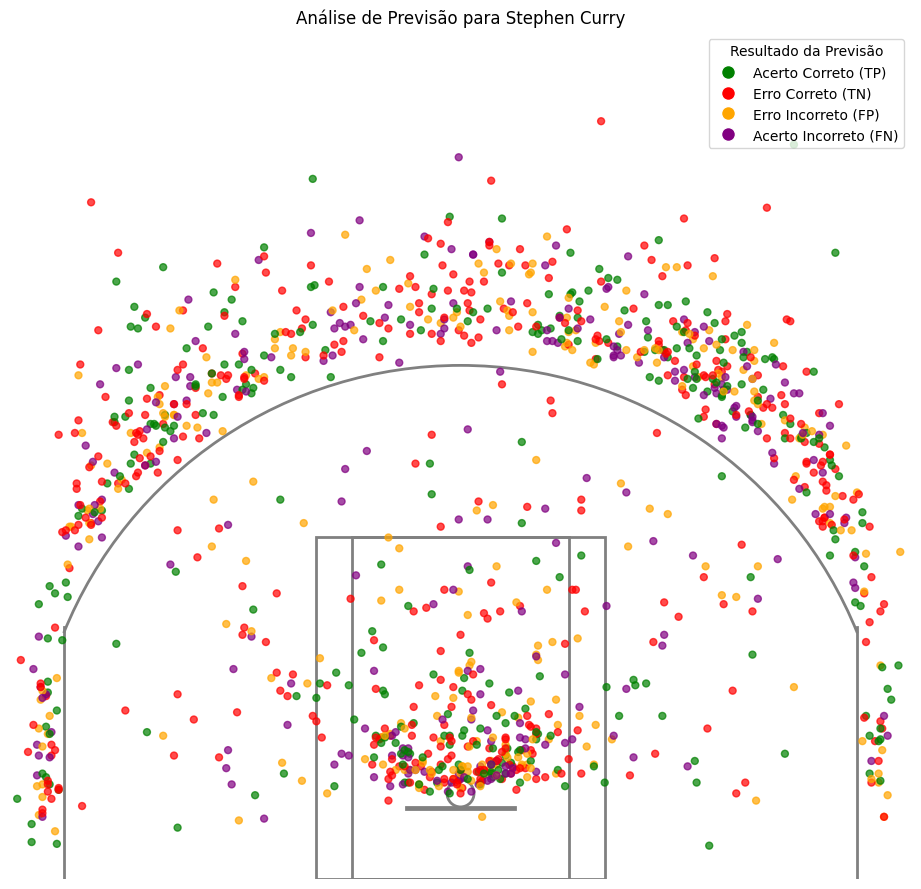

In [11]:
def draw_court(ax=None, color='gray', lw=2, zorder=0):
    if ax is None: ax = plt.gca()
    hoop = plt.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, zorder=zorder)
    backboard = plt.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, zorder=zorder)
    outer_box = plt.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False, zorder=zorder)
    inner_box = plt.Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False, zorder=zorder)
    three_point_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color, fill=False, zorder=zorder)
    ax.plot([-220, -220], [-47.5, 92.5], linewidth=lw, color=color, zorder=zorder)
    ax.plot([220, 220], [-47.5, 92.5], linewidth=lw, color=color, zorder=zorder)
    court_elements = [hoop, backboard, outer_box, inner_box, three_point_arc]
    for element in court_elements: ax.add_patch(element)
    return ax

def plot_player_analysis(player_name, df_results):
    df_player = df_results[df_results['player_name'] == player_name]
    if df_player.empty:
        print(f"Nenhum arremesso de {player_name} no conjunto de teste.")
        return

    # Definir cores para os resultados da previsão
    # Verde: Acerto Correto (TP)
    # Vermelho: Erro Correto (TN)
    # Laranja: Erro Incorreto (FP)
    # Roxo: Acerto Incorreto (FN)
    conditions = [
        (df_player['true_outcome'] == 1) & (df_player['predicted_outcome'] == 1), # TP
        (df_player['true_outcome'] == 0) & (df_player['predicted_outcome'] == 0), # TN
        (df_player['true_outcome'] == 0) & (df_player['predicted_outcome'] == 1), # FP
        (df_player['true_outcome'] == 1) & (df_player['predicted_outcome'] == 0)  # FN
    ]
    colors = ['green', 'red', 'orange', 'purple']
    df_player['result_color'] = np.select(conditions, colors, default='black')
    
    plt.figure(figsize=(12, 11))
    draw_court(plt.gca())
    plt.scatter(df_player['loc_x'], df_player['loc_y'], 
                c=df_player['result_color'], 
                alpha=0.7, s=25)
    
    # Criar legenda customizada
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Acerto Correto (TP)', markerfacecolor='green', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', label='Erro Correto (TN)', markerfacecolor='red', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', label='Erro Incorreto (FP)', markerfacecolor='orange', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', label='Acerto Incorreto (FN)', markerfacecolor='purple', markersize=10)]

    plt.legend(handles=legend_elements, title="Resultado da Previsão", loc='upper right')
    plt.title(f'Análise de Previsão para {player_name}')
    plt.xlim(-250, 250)
    plt.ylim(-47.5, 422.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.show()

# --- Execute a análise para os jogadores ---
plot_player_analysis("Stephen Curry", df_results)
#plot_player_analysis(1628369, df_results)

# Sessão 4 - Análise de Performance por Zona de Arremesso
<div class="markdown">
A análise moderna da NBA, popularizada por conceitos como "Moreyball", enfatiza que nem todos os arremessos são criados iguais. Arremessos na área restrita e de 3 pontos são considerados de alta eficiência, enquanto os de média distância são vistos como de baixa eficiência.   

Nossa hipótese é que o modelo deve ter uma performance melhor em zonas com resultados mais previsíveis (como a área restrita, onde a taxa de acerto é muito alta) e pode ter mais dificuldade em zonas onde o talento individual do arremessador é um fator mais decisivo (como a média distância). Vamos testar isso.

Performance do Modelo por Zona de Arremesso:


,total_shots,actual_fg_pct,model_accuracy
shot_zone_basic,,,
Above the Break 3,40879,0.475061,0.611439
Mid-Range,12606,0.473822,0.614152
Right Corner 3,6978,0.471912,0.616079
Restricted Area,37085,0.471781,0.620763
In The Paint (Non-RA),25940,0.471588,0.618504
Left Corner 3,7293,0.461813,0.617030
Backcourt,309,0.420712,0.624595


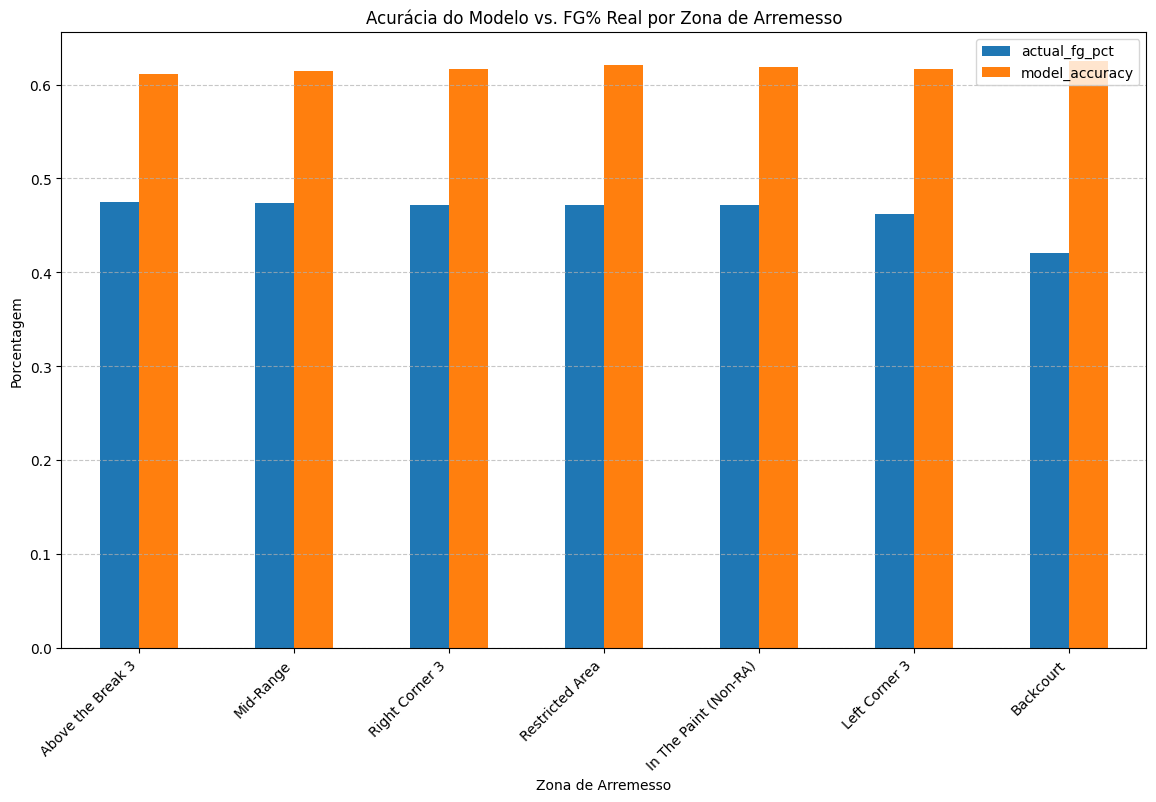

In [12]:
# Vamos calcular a acurácia do modelo para cada zona de arremesso
# e comparar com a taxa de acerto real (FG%) naquela zona.

# Agrupamos os resultados por 'shot_zone_basic'
zone_performance = df_results.groupby('shot_zone_basic').agg(
    total_shots=('shot_distance', 'count'),
    actual_fg_pct=('true_outcome', 'mean'),
    model_accuracy=('predicted_outcome', lambda x: (x == df_results.loc[x.index, 'true_outcome']).mean())
).sort_values(by='actual_fg_pct', ascending=False)

print("Performance do Modelo por Zona de Arremesso:")
display(zone_performance)

# Visualização para comparar
zone_performance.plot(kind='bar', y=['actual_fg_pct', 'model_accuracy'], figsize=(14, 8))
plt.title('Acurácia do Modelo vs. FG% Real por Zona de Arremesso')
plt.ylabel('Porcentagem')
plt.xlabel('Zona de Arremesso')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Sessão 5 Análise de "Qualidade do Arremesso" vs. Performance do Jogador - POE
<div class="markdown">
Uma das análises mais avançadas na NBA é comparar a performance real de um jogador com a performance "esperada" com base na qualidade de seus arremessos. Podemos usar nosso modelo para criar essa métrica!

A probabilidade de acerto que nosso modelo gera para cada arremesso pode ser vista como uma medida de "Qualidade do Arremesso" ou xP (Expected Points, em uma forma simplificada). Um arremesso aberto debaixo da cesta terá uma probabilidade alta (alta qualidade), enquanto um arremesso contestado de longe terá uma probabilidade baixa (baixa qualidade).

Vamos calcular quais jogadores, em nosso conjunto de teste, mais superaram ou ficaram abaixo das expectativas do modelo.
</div>

In [13]:
# --- Sessão 6: Código Corrigido ---

# As etapas 1 a 5 permanecem as mesmas...
# 1. Obter as probabilidades de acerto
shot_probabilities = best_model.predict_proba(X_test)[:, 1]
df_results['expected_fg_pct'] = shot_probabilities

# 2. Determinar o valor do arremesso
df_results['shot_value'] = df_results['shot_type'].apply(lambda x: 3 if '3PT' in x else 2)

# 3. Calcular os Expected Points (xP)
df_results['expected_points'] = df_results['expected_fg_pct'] * df_results['shot_value']

# 4. Calcular os Pontos Reais
df_results['actual_points'] = df_results['true_outcome'] * df_results['shot_value']

# 5. Calcular os Pontos Acima da Expectativa (POE)
df_results['points_over_expectation'] = df_results['actual_points'] - df_results['expected_points']

# --- AQUI ESTÁ A CORREÇÃO ---
# 6. Calcular o "viés" médio do modelo no conjunto de teste
mean_poe_bias = df_results['points_over_expectation'].mean()
print(f"Viés médio de POE do modelo: {mean_poe_bias:.4f}")

# 7. Criar a métrica de POE Ajustado
df_results['adjusted_poe'] = df_results['points_over_expectation'] - mean_poe_bias

# Agora, agregamos por jogador usando a nova métrica ajustada
player_poe_adjusted = df_results.groupby('player_name')['adjusted_poe'].agg(['mean', 'count', 'sum']).rename(columns={
    'mean': 'avg_adjusted_poe_per_shot',
    'count': 'shots_in_test_set',
    'sum': 'total_adjusted_poe'
})

# Filtramos para jogadores com um número razoável de arremessos
min_shots_threshold = 50
significant_players_poe_adj = player_poe_adjusted[player_poe_adjusted['shots_in_test_set'] >= min_shots_threshold]

# --- Jogadores que mais superam as expectativas (Elite Shot-Makers) ---
print("\nTop 10 Jogadores por Pontos Acima da Expectativa AJUSTADO (por arremesso):")
display(significant_players_poe_adj.sort_values(by='total_adjusted_poe', ascending=False).head(10))

# --- Jogadores que mais ficam abaixo das expectativas (Arremessadores Ineficientes) ---
print("\nTop 10 Jogadores por Pontos Abaixo da Expectativa AJUSTADO (por arremesso):")
display(significant_players_poe_adj.sort_values(by='total_adjusted_poe', ascending=True).head(10))

Viés médio de POE do modelo: -0.1657

Top 10 Jogadores por Pontos Acima da Expectativa AJUSTADO (por arremesso):


,avg_adjusted_poe_per_shot,shots_in_test_set,total_adjusted_poe
player_name,,,
Jordan Hawkins,0.135020,556,75.071353
Matas Buzelis,0.134425,555,74.605848
Dillon Brooks,0.077235,895,69.125159
Kristaps Porziņģis,0.110311,574,63.318767
Nikola Jokić,0.045254,1364,61.726980
Amen Thompson,0.083423,697,58.146075
Alperen Sengun,0.046521,1143,53.173448
Kyrie Irving,0.051154,945,48.340190
Bam Adebayo,0.038270,1113,42.595064



Top 10 Jogadores por Pontos Abaixo da Expectativa AJUSTADO (por arremesso):


,avg_adjusted_poe_per_shot,shots_in_test_set,total_adjusted_poe
player_name,,,
Austin Reaves,-0.078694,1037,-81.605858
Stephen Curry,-0.062238,1258,-78.295776
Ty Jerome,-0.125955,618,-77.840180
Bogdan Bogdanović,-0.150599,492,-74.094786
Anthony Black,-0.098356,620,-60.980448
Norman Powell,-0.054217,945,-51.234892
Donovan Mitchell,-0.036744,1320,-48.502012
Nikola Vučević,-0.045051,1038,-46.763134
Jamal Murray,-0.040959,1121,-45.914611


In [14]:
significant_players_poe_adj.loc['Stephen Curry']

avg_adjusted_poe_per_shot      -0.062238
shots_in_test_set            1258.000000
total_adjusted_poe            -78.295776
Name: Stephen Curry, dtype: float64

# Sessão 6 Validando a Hipótese do Arremessador de Alta Dificuldade (Estudo de Caso: Klay Thompson)
<div class="markdown">
Nossa análise de POE (Pontos Acima da Expectativa) revelou um resultado contraintuitivo: Trae Young, um arremessador de elite, foi classificado entre os jogadores de pior desempenho. Nossa hipótese é que isso ocorre porque o modelo penaliza seu volume extremo de arremessos de alta dificuldade (longa distância, fora do drible), que são arremessos de baixa probabilidade para um jogador médio da NBA.

Nesta sessão, vamos validar essa hipótese analisando o perfil de arremessos de Trae Young em nosso conjunto de teste.
</div>

Analisando 1258 arremessos de Stephen Curry no conjunto de teste.

Distância Média dos Arremessos de Stephen Curry: 19.47 pés
Distância Média dos Arremessos (Liga): 14.00 pés


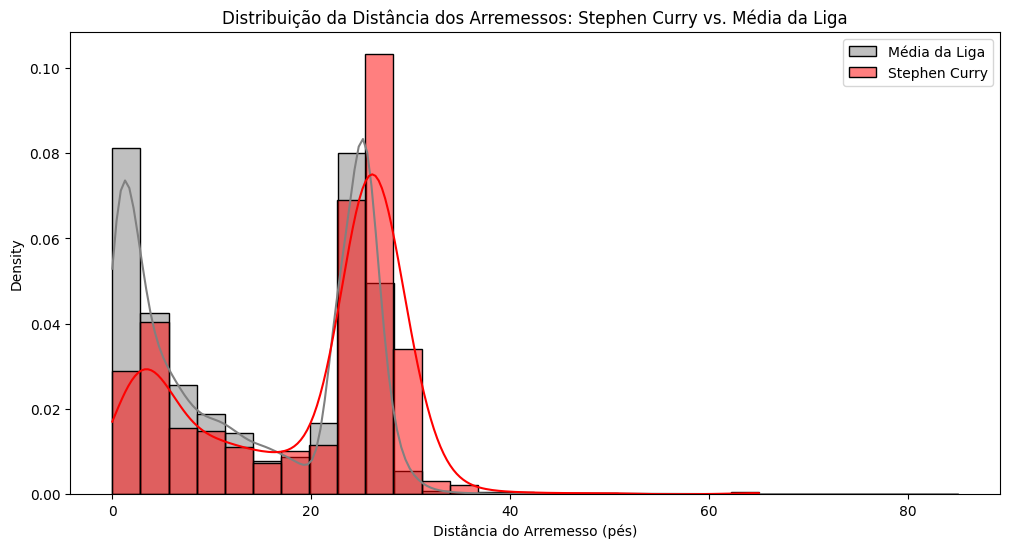


Top 5 Tipos de Arremesso Mais Frequentes para Stephen Curry:


action_type
Jump Shot                         27.74%
Pullup Jump shot                  21.46%
Step Back Jump shot               14.07%
Driving Layup Shot                 6.76%
Driving Finger Roll Layup Shot     5.88%
Name: proportion, dtype: object


Top 5 Tipos de Arremesso Mais Frequentes (Média da Liga):


action_type
Jump Shot                     28.49%
Pullup Jump shot              11.49%
Driving Layup Shot             8.52%
Driving Floating Jump Shot     6.01%
Step Back Jump shot            5.95%
Name: proportion, dtype: object

In [15]:
# Filtrar o DataFrame de resultados apenas para os arremessos de Trae Young
df_klay = df_results[df_results['player_name'] == 'Stephen Curry'].copy()

if not df_klay.empty:
    print(f"Analisando {len(df_klay)} arremessos de Stephen Curry no conjunto de teste.")

    # --- Análise da Distância do Arremesso ---
    avg_distance_trae = df_klay['shot_distance'].mean()
    avg_distance_league = df_results['shot_distance'].mean()

    print(f"\nDistância Média dos Arremessos de Stephen Curry: {avg_distance_trae:.2f} pés")
    print(f"Distância Média dos Arremessos (Liga): {avg_distance_league:.2f} pés")

    plt.figure(figsize=(12, 6))
    sns.histplot(df_results['shot_distance'], bins=30, color='gray', stat='density', label='Média da Liga', kde=True)
    sns.histplot(df_klay['shot_distance'], bins=23, color='red', stat='density', label='Stephen Curry', kde=True)
    plt.title('Distribuição da Distância dos Arremessos: Stephen Curry vs. Média da Liga')
    plt.xlabel('Distância do Arremesso (pés)')
    plt.legend()
    plt.show()

    # --- Análise do Tipo de Arremesso (Action Type) ---
    print("\nTop 5 Tipos de Arremesso Mais Frequentes para Stephen Curry:")
    display(df_klay['action_type'].value_counts(normalize=True).head(5).apply('{:.2%}'.format))

    print("\nTop 5 Tipos de Arremesso Mais Frequentes (Média da Liga):")
    display(df_results['action_type'].value_counts(normalize=True).head(5).apply('{:.2%}'.format))

else:
    print("Não foram encontrados arremessos de Stephen Curry no conjunto de teste para análise.")